In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [155]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import umap
plt.rcParams["font.family"] = "HanaMinA" 

In [4]:
kv = KeyedVectors.load("../data/fasttext-zh-sw/fasttext-zh-sw.kv")
kv.init_sims()

In [121]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load(topn=3000)

## Select target radicals

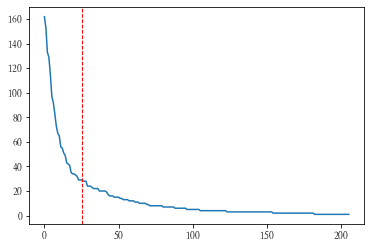

In [231]:
from collections import Counter
radical_freq = Counter(radicals.query(x)[0] for x in lexicon if not tsvars.is_simplified(x))
plt.plot([x[1] for x in radical_freq.most_common()])
plt.axvline(25, color="red", linestyle="--", linewidth=1)
common_radicals = [x[0] for x in radical_freq.most_common(25)]

In [192]:
target_radicals = [radicals.query("河")[0], radicals.query("情")[0]]

In [193]:
target_items = [(ch, x.index) for ch, x in kv.vocab.items() 
                if radicals.query(ch)[0] in target_radicals and
                   not tsvars.is_simplified(ch) and
                   ch in lexicon]
target_characters = [x[0] for x in target_items]
target_indices = [x[1] for x in target_items]

In [194]:
len(target_indices), len(target_characters)

(254, 254)

In [195]:
sub_vectors = np.zeros((len(target_indices), kv.vector_size))
for i, idx in enumerate(target_indices):
    sub_vectors[i, :] = kv.vectors[idx, :]

In [205]:
pca = PCA(2)
reducer = umap.UMAP(n_neighbors=5)
pca_proj = pca.fit_transform(sub_vectors)
umap_proj = reducer.fit_transform(sub_vectors)

In [206]:
umap_proj.shape, pca_proj.shape

((254, 2), (254, 2))

In [207]:
proj_data = pd.DataFrame(dict(
            char=target_characters, 
            radical=[radicals.query(x)[0] for x in target_characters],
            is_simp=[tsvars.is_simplified(x) for x in target_characters],
            umap1=umap_proj[:,0], umap2=umap_proj[:,1],
            pca1=pca_proj[:,0], pca2=pca_proj[:,1]
            ))

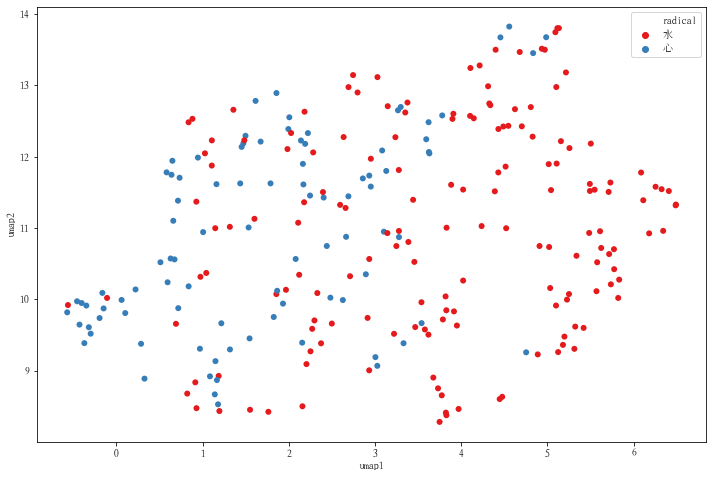

In [208]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=proj_data, x="umap1", y="umap2", hue="radical", edgecolor='none', palette="Set1")

## Permutation test

In [219]:
from sklearn import metrics
def compute_cluster_score(target_rads, n=1000):
    target_characters = []
    target_indices = []
    radical_labels = []
    for ch in lexicon:
        rad = radicals.query(ch)[0]
        if rad not in target_rads or\
           tsvars.is_simplified(ch) or\
           ch not in kv.vocab:
            continue
        target_characters.append(ch)
        target_indices.append(kv.vocab[ch].index)
        radical_labels.append(rad)        
    
    sub_vectors = np.zeros((len(target_indices), kv.vector_size))
    for i, idx in enumerate(target_indices):
        sub_vectors[i, :] = kv.vectors[idx, :]
    true_score = metrics.calinski_harabasz_score(sub_vectors, radical_labels)
    rand_score = []
    rs = np.random.RandomState(42)
    for i in range(1000):
        rand_radicals = radical_labels.copy()
        rs.shuffle(rand_radicals)
        score = metrics.calinski_harabasz_score(sub_vectors, rand_radicals)
        rand_score.append(score)
    rand_score = np.array(rand_score)
    return {"estimate": true_score,
            "pvalue": 1-np.sum(true_score > rand_score)/n,
            "permutes": rand_score}

In [232]:
from itertools import combinations
from tqdm import tqdm
perm_results = {}
rad_compos = list(combinations(common_radicals, 2))
for rad_a, rad_b in tqdm(rad_compos):    
    compo_key = tuple(sorted([rad_a, rad_b]))
    try:
        result = compute_cluster_score([rad_a, rad_b])            
        perm_results[compo_key] = result
    except Exception:
        print(rad_a, rad_b)
        perm_results[compo_key] = None

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:49<00:00,  2.73it/s]


In [234]:
import pickle
with open("../data/exp/radical_cluster_perm.pkl", "wb") as fout:
    pickle.dump(perm_results, fout)

In [240]:
sorted([(k, v["estimate"], v["pvalue"]) for k, v in perm_results.items()], key=lambda x: x[1])

[(('宀', '日'), 1.1514187805762977, 0.129),
 (('宀', '禾'), 1.2245049889225121, 0.08399999999999996),
 (('人', '禾'), 1.2366044800741265, 0.08999999999999997),
 (('禾', '阜'), 1.3261193991027282, 0.027000000000000024),
 (('禾', '竹'), 1.3538406260834344, 0.03200000000000003),
 (('刀', '禾'), 1.4150529147418784, 0.025000000000000022),
 (('刀', '竹'), 1.41556403811292, 0.018000000000000016),
 (('辵', '阜'), 1.4511844585242657, 0.007000000000000006),
 (('宀', '阜'), 1.4920556802836455, 0.0040000000000000036),
 (('人', '阜'), 1.5592497611030558, 0.0050000000000000044),
 (('日', '禾'), 1.5795994560831295, 0.006000000000000005),
 (('石', '竹'), 1.612228561609388, 0.0020000000000000018),
 (('禾', '辵'), 1.6333893536674342, 0.0030000000000000027),
 (('日', '阜'), 1.6650273349138278, 0.0),
 (('木', '禾'), 1.6813209495414552, 0.0),
 (('刀', '石'), 1.707163855356027, 0.0020000000000000018),
 (('刀', '阜'), 1.7316897375478983, 0.0020000000000000018),
 (('人', '宀'), 1.740040779636954, 0.0010000000000000009),
 (('人', '刀'), 1.75648345

In [227]:
compute_cluster_score(["水", "手"])

{'estimate': 8.614876197579337,
 'pvalue': 0.0,
 'permutes': array([0.76551288, 1.00438673, 1.03016778, 0.99656998, 1.00552277,
        0.98906745, 0.86037485, 0.98045914, 1.22280688, 1.00603076,
        0.90746806, 0.78673667, 0.88332915, 1.08836357, 0.92333306,
        0.99622808, 0.92838587, 1.14496199, 1.03255855, 0.892976  ,
        1.22817769, 1.01371569, 0.86827394, 0.89533235, 1.012724  ,
        0.8957212 , 0.88925924, 0.75679379, 0.8921342 , 0.80533947,
        0.99614069, 1.03113654, 1.3424304 , 0.93501694, 0.77143351,
        0.78688124, 0.86705761, 0.94902458, 1.10503478, 1.15618549,
        0.84261394, 0.86972243, 0.95980165, 0.90648164, 0.83394685,
        1.07882407, 0.95052015, 0.85112818, 1.38696542, 0.79812131,
        1.0659303 , 1.0031294 , 0.71421667, 0.79023514, 1.14719385,
        1.30531737, 1.07645258, 1.17320101, 0.88859849, 0.97517053,
        0.88964607, 0.89092637, 0.95545403, 0.74766861, 0.84763301,
        0.83679094, 0.93591838, 1.109024  , 1.20258421, 

In [204]:
plt.figure(figsize=(12,8))
rad_selected = 4
print(target_radicals[rad_selected])
rad_mask = proj_data.radical==target_radicals[rad_selected]
row_mask = rad_mask
plt.scatter(proj_data[proj_x], proj_data[proj_y], color="#AAAAFF", s=0)
# for item in proj_data.itertuples():        
#    plt.text(getattr(item, proj_x),
#              getattr(item, proj_y), item.char, 
#              fontsize=12,
#              color="#3333FF" if item.radical==target_radicals[0] else "#FF3333")    
plt.scatter(proj_data.loc[~row_mask, "umap1"], proj_data.loc[~row_mask, "umap2"], color="#9999FF", s=1)
plt.scatter(proj_data.loc[row_mask, "umap1"], proj_data.loc[row_mask, "umap2"], color="#FF3333", s=20)


IndexError: list index out of range

<Figure size 864x576 with 0 Axes>

## Component Matrix

In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [12]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [13]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [14]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)
decompo_matrix.shape

(6156, 2497)

In [15]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

In [16]:
aa = LabelEncoder()
aa.fit(["a", "b", "c"])

LabelEncoder()

In [17]:
sel_compo_idx = decompo_matrix.sum(axis=0)>1
sel_compo_enc = LabelEncoder()
sel_compo_enc.fit(compo_enc.classes_[sel_compo_idx])
decompo_matrix_reduced = decompo_matrix[:, sel_compo_idx]
print(decompo_matrix_reduced.shape)
la.matrix_rank(decompo_matrix_reduced)

(6156, 1407)


1407

In [18]:
## Character semantic vector
word_kv_idxs = []
for word in char_enc.classes_:
    word_kv_idxs.append(kv.vocab[word].index)
char_ft = kv.vectors_norm[word_kv_idxs, :]
char_ft.shape

(6156, 300)

## Component semantic matrix
$$
C_{k\times d}: \textrm{Component semantic matrix, k components $\times$ d vector size }\\
Z_{n\times d}: \textrm{Character semantic matrix, n characters $\times$ d vector size }\\
D_{n\times k}: \textrm{Decomposition matrix, n characters $\times$ k components}\\
Z = D\cdot C\\
C = (D^\top D)^{-1}D^\top Z
$$

In [19]:
import numpy as np
import numpy.linalg as la

D = decompo_matrix_reduced
Z = char_ft
print("D, Z: ", D.shape, Z.shape)
compo_ft = la.inv(D.T.dot(D)).dot(D.T).dot(Z)

D, Z:  (6156, 1407) (6156, 300)


In [20]:
Zhat = D.dot(compo_ft)
R = Z.dot(Zhat.T)

In [21]:
def query_component(compo, is_trad=True):
    if is_trad is not None:
        compo = compo + ("_t" if is_trad else "_s")
    compo_vec = compo_ft[sel_compo_enc.transform([compo])[0]]
    return compo_vec

In [22]:
list(zip(kv.similar_by_vector(query_component("又", is_trad=True)),
    kv.similar_by_vector(query_component("又", is_trad=False))))

[(('而', 0.9840849041938782), ('却', 0.9875600934028625)),
 (('即', 0.9838416576385498), ('虽', 0.9869415760040283)),
 (('亦', 0.9832538366317749), ('则', 0.9865677356719971)),
 (('取', 0.9828312397003174), ('对', 0.9858291149139404)),
 (('如', 0.9821022748947144), ('说', 0.9856451749801636)),
 (('也', 0.9820734858512878), ('当', 0.9855595827102661)),
 (('之', 0.9817055463790894), ('与', 0.9846853017807007)),
 (('以', 0.9816076159477234), ('贤', 0.9843353629112244)),
 (('便', 0.981594979763031), ('还', 0.9842792749404907)),
 (('和', 0.9814806580543518), ('许', 0.9842578768730164))]

In [23]:
{v: k for k, v in radicals.ts_radicals.items()}["金"]

'钅'

In [24]:
tsvars.is_traditional("妻")

False

In [25]:
list(zip(kv.similar_by_vector(query_component("女", is_trad=True)),
    kv.similar_by_vector(query_component("女", is_trad=False))))

[(('妹', 0.9858518838882446), ('婶', 0.9854856133460999)),
 (('媚', 0.9857202768325806), ('嬷', 0.9837477803230286)),
 (('妻', 0.9856017827987671), ('敫', 0.9828739166259766)),
 (('姊', 0.9844710826873779), ('嫫', 0.9827786087989807)),
 (('逅', 0.9835814833641052), ('鐏', 0.9814938306808472)),
 (('嫂', 0.9832499623298645), ('姘', 0.9814498424530029)),
 (('婷', 0.9830593466758728), ('祃', 0.981367826461792)),
 (('綺', 0.9828788638114929), ('齹', 0.9809126257896423)),
 (('竟', 0.9828314185142517), ('婵', 0.9808992147445679)),
 (('玔', 0.9827866554260254), ('娆', 0.9808309078216553))]

In [26]:
list(zip(kv.similar_by_vector(query_component("金", is_trad=True)),
    kv.similar_by_vector(query_component("钅", is_trad=False))))

[(('鉆', 0.9834352135658264), ('熂', 0.9849629998207092)),
 (('搆', 0.9824538826942444), ('钣', 0.9849522709846497)),
 (('竉', 0.9824486374855042), ('毂', 0.9833048582077026)),
 (('鑄', 0.9819265007972717), ('铅', 0.9829593300819397)),
 (('鋃', 0.981760561466217), ('灮', 0.982614278793335)),
 (('袗', 0.9815495014190674), ('裎', 0.9825872182846069)),
 (('犠', 0.9815448522567749), ('铤', 0.9823060035705566)),
 (('緃', 0.9814175367355347), ('诽', 0.9819009900093079)),
 (('拑', 0.9813220500946045), ('鐏', 0.9815917611122131)),
 (('牐', 0.9808732271194458), ('拧', 0.9815613031387329))]

In [27]:
list(zip(kv.similar_by_vector(query_component("金", is_trad=True)),
    kv.similar_by_vector(query_component("钅", is_trad=False))))

[(('鉆', 0.9834352135658264), ('熂', 0.9849629998207092)),
 (('搆', 0.9824538826942444), ('钣', 0.9849522709846497)),
 (('竉', 0.9824486374855042), ('毂', 0.9833048582077026)),
 (('鑄', 0.9819265007972717), ('铅', 0.9829593300819397)),
 (('鋃', 0.981760561466217), ('灮', 0.982614278793335)),
 (('袗', 0.9815495014190674), ('裎', 0.9825872182846069)),
 (('犠', 0.9815448522567749), ('铤', 0.9823060035705566)),
 (('緃', 0.9814175367355347), ('诽', 0.9819009900093079)),
 (('拑', 0.9813220500946045), ('鐏', 0.9815917611122131)),
 (('牐', 0.9808732271194458), ('拧', 0.9815613031387329))]

In [28]:
simp_radicals = [x+"_s" for x in radicals.ts_radicals.keys()]
trad_radicals = [x+"_t" for x in radicals.ts_radicals.values()]
targets = [("又_s", "又_t"), ("言_s", "言_t"), ("女_s", "女_t")]

rois = []
for s, t in targets:
    if s in sel_compo_enc.classes_ and \
       t in sel_compo_enc.classes_:
        rois += [s, t]
print("rois count: ", len(rois))
for srad, trad in zip(simp_radicals, trad_radicals):
    if srad in sel_compo_enc.classes_ and \
       trad in sel_compo_enc.classes_:
        rois += [srad, trad]
print("rois count: ", len(rois))

rois count:  6
rois count:  46


In [29]:
roi_vectors = np.zeros((len(rois), compo_ft.shape[1]), dtype=np.float)
for roi_idx, roi_x in enumerate(rois):
    roi_vectors[roi_idx] = query_component(roi_x, is_trad=None)

In [30]:
roi_vectors.shape

(46, 300)

In [31]:
from sklearn.decomposition import PCA
roi_pca = PCA(3)
roi_2d = roi_pca.fit_transform(roi_vectors)

In [32]:
from matplotlib import font_manager

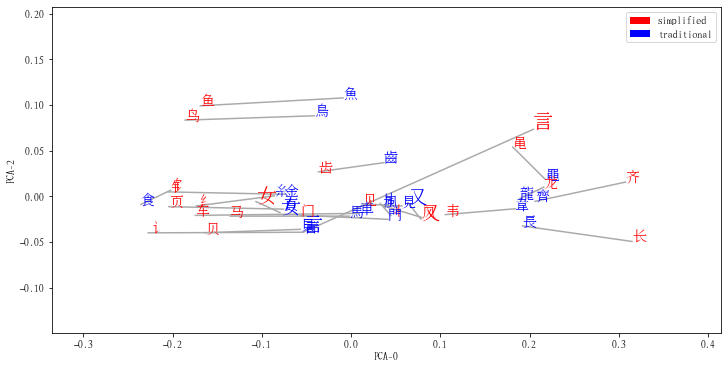

In [34]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "HanaMinA" 
plt.figure(figsize=(12,6))
idx_iter = iter(range(len(rois)))
dim_x = 0
dim_y = 2
for s_idx, t_idx in zip(*([idx_iter]*2)):
    s_compo = rois[s_idx].split("_")[0]
    t_compo = rois[t_idx].split("_")[0]
    
    text_args = dict(fontsize=14)
    if (rois[s_idx], rois[t_idx]) in targets:
        text_args["fontsize"]=20
    
    plt.text(roi_2d[s_idx, dim_x], roi_2d[s_idx, dim_y], 
             s_compo, color="red", **text_args)
    plt.text(roi_2d[t_idx, dim_x], roi_2d[t_idx, dim_y], 
             t_compo, color="blue", **text_args)
    plt.plot(roi_2d[[s_idx, t_idx], dim_x], roi_2d[[s_idx, t_idx], dim_y], color='#AAAAAA')
coord_max = roi_2d.max(axis=0)+0.1
coord_min = roi_2d.min(axis=0)-0.1
plt.xlim(coord_min[dim_x], coord_max[dim_x])
plt.ylim(coord_min[dim_y], coord_max[dim_y])
plt.xlabel(f"PCA-{dim_x}")
plt.ylabel(f"PCA-{dim_y}")
from matplotlib.patches import Patch
h_legends = [Patch(facecolor="red", label="simplified"),
             Patch(facecolor="blue", label="traditional")]
plt.legend(handles=h_legends, loc="upper right")